In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import re
import matplotlib as plt


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
import time
from sklearn import svm

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing dataset
cols_list = ["Polarity", "Text"]
data = pd.read_csv(r'/content/drive/MyDrive/data.csv', usecols = cols_list)
# data

In [ ]:
data = data.drop_duplicates()

In [ ]:
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

In [ ]:
import seaborn as sns
sns.countplot(data = data, x = 'Polarity')

In [ ]:
# Clean and process tweets
# stemmer = PorterStemmer()

def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp)  # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+", "", temp)  # remove mentions
    temp = re.sub("#[A-Za-z0-9_]+", "", temp)  # remove hashtags
    temp = re.sub(r'http\S+', '', temp)  # remove urls
    temp = re.sub('[()!?]', ' ', temp)  # remove special characters
    temp = re.sub('\[.*?\]', ' ', temp)
    temp = re.sub("[^a-z0-9]", " ", temp)  # convert all to lower case
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords.words('english')]
    # temp = [stemmer.stem(word) for word in tweet]
    temp = " ".join(word for word in temp)
    return temp
data['Text'] = data['Text'].apply(clean_tweet)
# data

Tweet length distribution

In [ ]:
!pip install plotly_express

In [ ]:
import plotly_express as px
data["tweet_length"] = data.Text.map(lambda x: len(x))
px.histogram(data[data["tweet_length"] < 1000], x="tweet_length", color="Polarity", title="Twitters Length Distribution Plot")


Data length distribution

In [ ]:
px.histogram(df[df["tweet_length"] < 1000], x="tweet_length", color="cyberbullying_type", title="Twitters Length Distribution Plot")

Visualizing contents of tweets

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def display_word_cloud(field_name, title):
    words = data[data['Polarity'] == field_name].Text
    cloud = WordCloud(background_color='black', width=2000, height=1000, colormap="viridis", collocations=False).generate(" ".join(words))
    # plt.axis('off')
    plt.title(title,fontsize=40)
    plt.imshow(cloud)
display_word_cloud("gender", "Gender")

In [ ]:
display_word_cloud("age", "Age")

In [ ]:
display_word_cloud("ethnicity", "Ethnicity")

In [ ]:
display_word_cloud("religion", "Religion")

In [ ]:
display_word_cloud("other_cyberbullying", "Other Cyberbullying")

In [ ]:
display_word_cloud("not_cyberbullying", "Not Cyberbullying")

Classification

In [ ]:
# Distinguish tweets with positive and negative sentiments
data['Polarity'] = data['Polarity'].apply(lambda x: 1 if x == 'positive' else 0)

In [ ]:
data = data.loc[:, ['Text', 'Polarity']]

In [ ]:
# tokenization
tknzr = TweetTokenizer()
data["tokenized"] = [tknzr.tokenize(i) for i in data['Text']]

In [ ]:
# split data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=1)
X_train = train['Text'].values
X_test = test['Text'].values
y_train = train['Polarity']
y_test = test['Polarity']

In [ ]:
# vectorization
# vectorizer = TfidfVectorizer(min_df=5,
#                              max_df=0.8,
#                              sublinear_tf=True,
#                              use_idf=True)

vectorizer = CountVectorizer(
    analyzer = 'word',
    # tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1))
    # stop_words = en_stopwords)
train_vectors = vectorizer.fit_transform(train['Text'])
test_vectors = vectorizer.transform(test['Text'])

In [ ]:
print(train_vectors)

In [ ]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer,
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]},
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,
                    n_jobs=-1)

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.8233265590705294

In [ ]:
grid_svm.best_params_

{'svc__C': 0.1}

In [ ]:
grid_svm.best_score_

0.8861713445219085

In [ ]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    auc = roc_auc_score(y, pred_proba)
    result = {'auc': auc}
    return result

In [ ]:
report_results(grid_svm.best_estimator_,  X_test, y_test)

{'acc': 0.7724217601344255,
 'auc': 0.8890636064898677,
 'f1': 0.5721618953603159,
 'precision': 0.4143551615670575,
 'recall': 0.9241071428571429}

In [ ]:
# y_predict = report_results(grid_svm.best_estimator_,  X_test, y_test)
y_predict = grid_svm.predict(X_test)
y_predict


array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
cm
confusion = pd.DataFrame(cm, index=['cyberbullying', 'not_cyberbullying'],
                         columns=['predicted_cyberbullying', 'predicted_not_cyberbullying'])
confusion

,predicted_cyberbullying,predicted_not_cyberbullying
cyberbullying,5906,2048
not_cyberbullying,119,1449


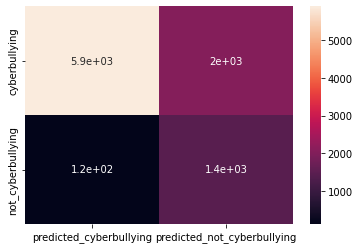

In [ ]:
import seaborn as sns
sns.heatmap(confusion, annot=True)

In [ ]:
def get_roc_curve(model, X, y):
  pred_proba = model.predict_proba(X)[:, 1]
  fpr, tpr, _ = roc_curve(y, pred_proba)
  return fpr, tpr

In [ ]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)


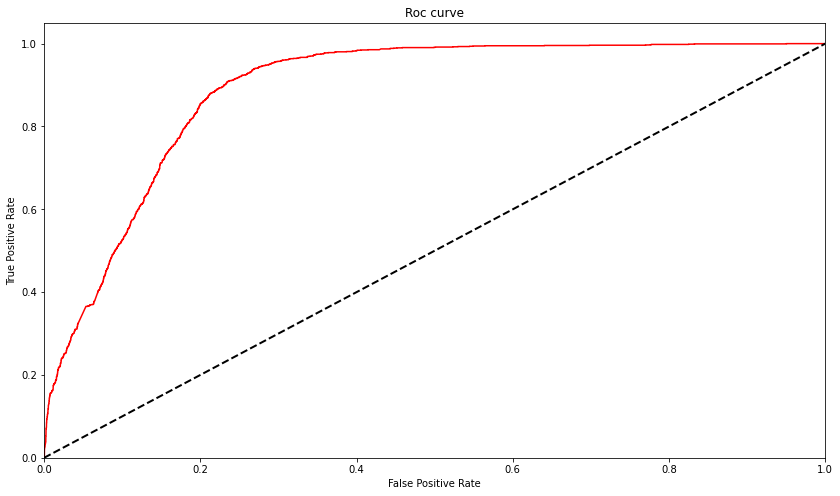

In [ ]:
import matplotlib.pyplot as plt
fpr, tpr = roc_svm
plt.figure(figsize = (14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1,
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="lower right")
    return plt


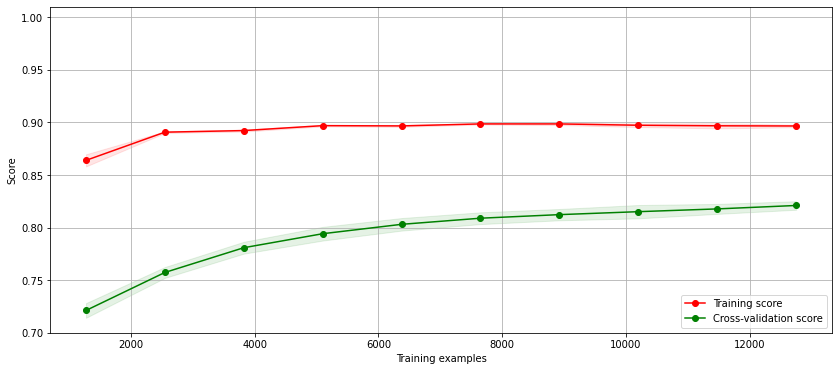

In [ ]:
plot_learning_curve(X_train, y_train, train_sizes, train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

In [ ]:
if grid_svm.predict == 1:
  print("This statement is positive")
else:
  print("This statement is negative")

In [ ]:
grid_svm.predict([" Fuck you "])

array([0])

In [ ]:
grid_svm.predict(["I hate you"])

array([0])

In [ ]:
grid_svm.predict(["I love you"])

array([1])

In [ ]:
grid_svm.predict(["You look great"])

array([1])

In [ ]:
grid_svm.predict(["Son of a b*tch"])

array([0])

In [ ]:
grid_svm.predict(["Suck my d*ck"])

array([0])

In [ ]:
grid_svm.predict(["do you believe in life after death?"])

array([1])